In [1]:
import numpy as np
import os
import pandas as pd
import scipy.interpolate
import sklearn.metrics
import sys
sys.path.append("../src")
import localmodule


from matplotlib import pyplot as plt
%matplotlib inline

# Define constants.
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
n_thresholds = 221
n_trials = 10
n_eval_trials = 5


# Initialize dicts.
report = {}


# Loop over augmentations.
for model_name in [
#        "icassp-convnet",
        "icassp-convnet_aug-all",
        "pcen-convnet_aug-all",
        "icassp-add-convnet_aug-all-but-noise",
        "icassp-ntt-convnet_aug-all-but-noise"
]:

    # Initialize dictionaries
    aug_report = {
        "validation": {},
        "test-CV-AUPRC": {},
        "test-CV-F": {},
        "test-oracle-AUPRC": {},
        "test-oracle-F": {},
    }


    val_precisions = np.zeros((n_units, n_trials))
    val_recalls = np.zeros((n_units, n_trials))
    val_f1_scores = np.zeros((n_units, n_trials))
    val_auprcs = np.zeros((n_units, n_trials))
    val_thresholds = np.zeros((n_units, n_trials))
    val_threshold_ids = np.zeros((n_units, n_trials))


    thresholds = 1.0 - np.concatenate((
        np.logspace(-9, -2, 141), np.delete(np.logspace(-2, 0, 81), 0)
    ))
    n_thresholds = len(thresholds)


    # Define model directory
    model_dir = os.path.join(models_dir, model_name)


    # Loop over test units.
    for test_unit_id in range(n_units):

        test_unit_str = units[test_unit_id]
        test_unit_dir = os.path.join(model_dir, test_unit_str)

        # Retrieve fold such that unit_str is in the test set.
        folds = localmodule.fold_units()
        fold = [f for f in folds if test_unit_str in f[0]][0]
        test_units = fold[0]
        validation_units = fold[2]

        # Loop over trials.
        for trial_id in range(n_trials):

            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)
            break_switch = False

            # Loop over validation units.
            for predict_unit_str in validation_units:
                val_metrics_name = "_".join([
                    dataset_name,
                    model_name,
                    "test-" + test_unit_str,
                    trial_str,
                    "predict-" + predict_unit_str,
                    "full-audio-metrics.csv"
                ])
                val_metrics_path = os.path.join(trial_dir, val_metrics_name)
                val_tp = np.zeros((n_thresholds,))
                val_fp = np.zeros((n_thresholds,))
                val_fn = np.zeros((n_thresholds,))
                try:
                    val_metrics_df = pd.read_csv(val_metrics_path)
                    val_tp = val_tp + np.array(val_metrics_df["True positives"])
                    val_fp = val_fp + np.array(val_metrics_df["False positives"])
                    val_fn = val_fn + np.array(val_metrics_df["False negatives"])
                except:
                    print(val_metrics_path)
                    break_switch = True
                    break

            if break_switch:
                val_auprc = 0.0
                val_p = np.zeros((n_thresholds,))
                val_r = np.zeros((n_thresholds,))
                val_f = np.zeros((n_thresholds,))
                val_threshold_id = 0
            else:
                val_p = val_tp / (np.finfo(float).eps + val_tp + val_fp)
                val_r = val_tp / (np.finfo(float).eps + val_tp + val_fn)
                val_f = 2*val_p*val_r / (np.finfo(float).eps+(val_p+val_r))
                val_threshold_id = np.argmax(val_f)
                val_p_ = np.array([1.0] + list(val_p) + [0.0])
                val_r_ = np.array([0.0] + list(val_r) + [1.0])
                val_auprc = sklearn.metrics.auc(val_r_, val_p_, reorder=True)

            val_precisions[test_unit_id, trial_id] = val_p[val_threshold_id]
            val_recalls[test_unit_id, trial_id] = val_r[val_threshold_id]
            val_f1_scores[test_unit_id, trial_id] = val_f[val_threshold_id]
            val_thresholds[test_unit_id, trial_id] = thresholds[val_threshold_id]
            val_threshold_ids[test_unit_id, trial_id] = val_threshold_id
            val_auprcs[test_unit_id, trial_id] = val_auprc


    aug_report["validation"]["P"] = val_precisions
    aug_report["validation"]["R"] = val_recalls
    aug_report["validation"]["F"] = val_f1_scores
    aug_report["validation"]["AUPRC"] = val_auprcs
    aug_report["validation"]["threshold"] = val_thresholds
    aug_report["validation"]["threshold_ids"] = val_threshold_ids
    aug_report["validation"]["trials_F"] = np.argsort(val_f1_scores, axis=1)
    aug_report["validation"]["trials_AUPRC"] = np.argsort(val_auprcs, axis=1)


    # Loop over test trials.
    auprc_eval_trials = np.sort(aug_report["validation"]["trials_AUPRC"][:, -5:], axis=1)
    test_auprcs = np.zeros((n_eval_trials,))
    test_precisions = np.zeros((n_thresholds, n_eval_trials))
    test_recalls = np.zeros((n_thresholds, n_eval_trials))
    test_f1_scores = np.zeros((n_thresholds, n_eval_trials))

    for eval_trial_id in range(n_eval_trials):
        test_tp = np.zeros((n_thresholds,))
        test_fp = np.zeros((n_thresholds,))
        test_fn = np.zeros((n_thresholds,))

        for test_unit_id in range(n_units):
            test_unit_str = units[test_unit_id]
            test_unit_dir = os.path.join(model_dir, test_unit_str)
            trial_id = auprc_eval_trials[test_unit_id, eval_trial_id]
            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)

            # Load test predictions.
            test_metrics_name = "_".join([
                dataset_name,
                model_name,
                "test-" + test_unit_str,
                trial_str,
                "predict-" + test_unit_str,
                "full-audio-metrics.csv"
            ])
            test_metrics_path = os.path.join(trial_dir, test_metrics_name)
            try:
                test_metrics_df = pd.read_csv(test_metrics_path)
                test_tp = test_tp + np.array(test_metrics_df["True positives"])
                test_fp = test_fp + np.array(test_metrics_df["False positives"])
                test_fn = test_fn + np.array(test_metrics_df["False negatives"])
            except:
                print(test_metrics_path)

        test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
        test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
        test_p_ = np.array([1.0] + list(test_p) + [0.0])
        test_r_ = np.array([0.0] + list(test_r) + [1.0])
        test_auprc = sklearn.metrics.auc(test_r_, test_p_, reorder=True)

        test_auprcs[eval_trial_id] = test_auprc
        test_precisions[:, eval_trial_id] = test_p
        test_recalls[:, eval_trial_id] = test_r
        test_f1_scores[:, eval_trial_id] =\
            (2*test_p*test_r) / (np.finfo(float).eps+test_p+test_r)


    aug_report["test-CV-AUPRC"]["AUPRC"] = test_auprcs
    aug_report["test-CV-AUPRC"]["P"] = test_precisions
    aug_report["test-CV-AUPRC"]["R"] = test_recalls
    aug_report["test-CV-AUPRC"]["F"] = test_f1_scores


    all_test_recalls = np.array(list(np.sort(np.ravel(test_recalls))))
    interpolated_precisions = np.zeros((2 + len(all_test_recalls), n_eval_trials))

    for eval_trial_id in range(n_eval_trials):
        precision_interpolator = scipy.interpolate.interp1d(
            np.array([0.0] + list(test_recalls[:, eval_trial_id]) + [1.0]),
            np.array([1.0] + list(test_precisions[:, eval_trial_id]) + [1.0]))
        interpolated_precisions[:, eval_trial_id] =\
            np.array([1.0] + list(precision_interpolator(all_test_recalls)) + [0.0])

    interpolated_recalls = np.array([0.0] + list(all_test_recalls) + [1.0])
    aug_report["test-CV-AUPRC"]["interpolated_P"] = np.sort(interpolated_precisions, axis=1)
    aug_report["test-CV-AUPRC"]["interpolated_R"] = interpolated_recalls
    aug_report["test-CV-AUPRC"]["interpolated_F"] =\
        (2*aug_report["test-CV-AUPRC"]["interpolated_P"]*aug_report["test-CV-AUPRC"]["interpolated_R"][:, np.newaxis]) /\
        (aug_report["test-CV-AUPRC"]["interpolated_P"]+aug_report["test-CV-AUPRC"]["interpolated_R"][:, np.newaxis])


    # Estimate F1 score.
    f_eval_trials = np.sort(aug_report["validation"]["trials_F"][:, -5:], axis=1)
    test_precisions = np.zeros((n_eval_trials,))
    test_recalls = np.zeros((n_eval_trials,))
    test_f1_scores = np.zeros((n_eval_trials,))

    for eval_trial_id in range(n_eval_trials):
        test_tp = 0
        test_fp = 0
        test_fn = 0

        for test_unit_id in range(n_units):
            test_unit_str = units[test_unit_id]
            test_unit_dir = os.path.join(model_dir, test_unit_str)
            trial_id = f_eval_trials[test_unit_id, eval_trial_id]
            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)
            
            threshold_id = int(aug_report["validation"]["threshold_ids"][
                test_unit_id, trial_id])

            # Load test predictions.
            test_metrics_name = "_".join([
                dataset_name,
                model_name,
                "test-" + test_unit_str,
                trial_str,
                "predict-" + test_unit_str,
                "full-audio-metrics.csv"
            ])
            test_metrics_path = os.path.join(trial_dir, test_metrics_name)
            test_metrics_df = pd.read_csv(test_metrics_path)
            test_tp = test_tp + np.array(test_metrics_df["True positives"])[threshold_id]
            test_fp = test_fp + np.array(test_metrics_df["False positives"])[threshold_id]
            test_fn = test_fn + np.array(test_metrics_df["False negatives"])[threshold_id]

        test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
        test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
        test_f = 2*test_p*test_r / (np.finfo(float).eps+test_p+test_r)

        test_precisions[eval_trial_id] = test_p
        test_recalls[eval_trial_id] = test_r
        test_f1_scores[eval_trial_id] =\
            (2*test_p*test_r) / (np.finfo(float).eps+test_p+test_r)
            
    aug_report["test-CV-F"]["P"] = test_precisions
    aug_report["test-CV-F"]["R"] = test_recalls
    aug_report["test-CV-F"]["F"] = test_f1_scores
    
    report[model_name] = aug_report

/scratch/vl1019/BirdVox-70k_models/icassp-convnet_aug-all/unit01/trial-8/BirdVox-70k_icassp-convnet_aug-all_test-unit01_trial-8_predict-unit07_full-audio-metrics.csv
/scratch/vl1019/BirdVox-70k_models/icassp-convnet_aug-all/unit02/trial-1/BirdVox-70k_icassp-convnet_aug-all_test-unit02_trial-1_predict-unit01_full-audio-metrics.csv
/scratch/vl1019/BirdVox-70k_models/icassp-convnet_aug-all/unit02/trial-3/BirdVox-70k_icassp-convnet_aug-all_test-unit02_trial-3_predict-unit10_full-audio-metrics.csv
/scratch/vl1019/BirdVox-70k_models/icassp-convnet_aug-all/unit03/trial-1/BirdVox-70k_icassp-convnet_aug-all_test-unit03_trial-1_predict-unit01_full-audio-metrics.csv
/scratch/vl1019/BirdVox-70k_models/icassp-convnet_aug-all/unit03/trial-4/BirdVox-70k_icassp-convnet_aug-all_test-unit03_trial-4_predict-unit01_full-audio-metrics.csv
/scratch/vl1019/BirdVox-70k_models/icassp-convnet_aug-all/unit03/trial-6/BirdVox-70k_icassp-convnet_aug-all_test-unit03_trial-6_predict-unit01_full-audio-metrics.csv
/scr

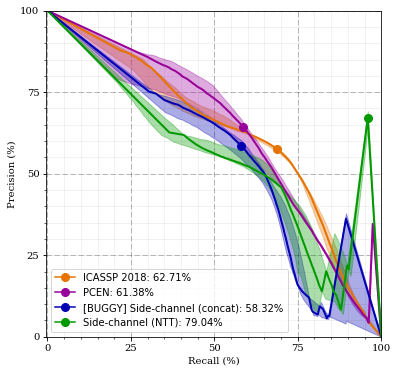

In [8]:
import matplotlib
from matplotlib import pyplot as plt
sorted_precisions = np.sort(interpolated_precisions, axis=1)

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 6))

model_colors = [
#    "#CB0003", 
    "#E67300",
    "#990099",
    "#0000B2",
    "#009900"
]
model_names = list(report.keys())
model_legends = []

model_captions = {
    "icassp-convnet": "CNN baseline",
    "pcen-convnet_aug-all": "PCEN",
    "icassp-convnet_aug-all": "ICASSP 2018",
    "icassp-add-convnet_aug-all-but-noise": "[BUGGY] Side-channel (concat)",
    "icassp-ntt-convnet_aug-all-but-noise": "Side-channel (NTT)",
}

eval_mode = "test-CV-AUPRC"

for model_id, model_name in enumerate(model_names):
    
    median_p = report[model_name][eval_mode]["interpolated_P"][:, 2]
    median_r = report[model_name][eval_mode]["interpolated_R"]
    median_f = 2 * median_p * median_r / (median_p + median_r)
    median_th = np.argmax(median_f)
    best_p = median_p[median_th]
    best_r = median_r[median_th]
    best_f = median_f[median_th]

    model_color = model_colors[model_id]
    
    ax.fill_between(
        100 * report[model_name][eval_mode]["interpolated_R"],
        100 * report[model_name][eval_mode]["interpolated_P"][:, 1],
        100 * report[model_name][eval_mode]["interpolated_P"][:, 3],
        color = model_color,
        alpha = 0.33);

    ax.plot(
        100 * report[model_name][eval_mode]["interpolated_R"],
        100 * report[model_name][eval_mode]["interpolated_P"][:, 2],
        color = model_color,
        linewidth = 2.0
    )
    
    cv_p = np.mean(report[model_name]["test-CV-F"]["P"])
    cv_r = np.mean(report[model_name]["test-CV-F"]["R"])
    cv_f = np.mean(report[model_name]["test-CV-F"]["R"])
    
    plot_r = [100*best_r]
    plot_p = [100*best_p]
    plot_f = 100*best_f
    ax.plot(plot_r, plot_p, "o", color=model_color, markersize=8.0)
    
    model_legend = matplotlib.lines.Line2D([], [], color=model_color, marker='o',
        markersize=8, label=model_captions[model_name] + ": {:5.2f}%".format(plot_f))
    model_legends.append(model_legend)

    
plt.legend(handles=model_legends)
    
    
############################### AXES AND GRID ###################################

major_ticks = np.linspace(0, 100, 5).astype("int")
minor_ticks = np.linspace(0, 100, 21).astype("int")

ax.set_xlim(-0.3, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticklabels(map(str, major_ticks), family="serif");
ax.set_xlabel("Recall (%)", family="serif");

ax.set_ylim(0.0, 100)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.set_yticklabels(map(str, major_ticks), family="serif");
ax.set_ylabel("Precision (%)", family="serif");

ax.grid(color='k', linestyle='--', linewidth=1.0, alpha=0.25, which="major")
ax.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.1, which="minor")
ax.set_axisbelow(True)

In [5]:
report[model_name]["test-CV-F"]

{'F': array([ 0.4108178 ,  0.4541727 ,  0.50213417,  0.27617351,  0.5503435 ]),
 'P': array([ 0.30522981,  0.34056387,  0.4061906 ,  0.18041353,  0.46676886]),
 'R': array([ 0.62809404,  0.68152183,  0.65741864,  0.58858062,  0.6703734 ])}

In [3]:
Ps = ["{:5.2f}%".format(100*np.mean(report[x]["test-CV-F"]["P"])) for x in report]
Rs = ["{:5.2f}%".format(100*np.mean(report[x]["test-CV-F"]["R"])) for x in report]
F1s = ["{:5.2f}%".format(100*np.mean(report[x]["test-CV-F"]["F"])) for x in report]
AUCs = ["{:5.2f}%".format(100*np.mean(report[x]["test-CV-AUPRC"]["AUPRC"])) for x in report]
metrics = [Ps, Rs, F1s, AUCs]

import pandas as pd
pd.DataFrame([Ps, Rs, F1s, AUCs], columns=model_names,
             index=["Precision", "Recall", "F1 score", "AUPRC"]).T

,Precision,Recall,F1 score,AUPRC
icassp-convnet_aug-all,50.40%,68.42%,57.95%,62.27%
pcen-convnet_aug-all,53.96%,63.01%,58.01%,61.81%
icassp-add-convnet_aug-all-but-noise,34.96%,59.34%,42.07%,52.79%
icassp-ntt-convnet_aug-all-but-noise,33.98%,64.52%,43.87%,52.78%


In [72]:


############################# PRINT RESULTS ###################################

print("CONVNET:      P = {:5.2f}%,  R = {:5.2f}%,  F = {:5.2f}%".format(
    100*best_cnn_p, 100*best_cnn_r, 100*best_cnn_f))
ax.text(100*best_cnn_r - 22.0 , 100*best_cnn_p - 9.0,
    "    convnet\n F = {:5.2f}%".format(100*best_cnn_f),
    color="#CB0003", fontsize=11.0, family="serif",
    backgroundcolor="white")


print("ICASSP 2018:  P = {:5.2f}%,  R = {:5.2f}%,  F = {:5.2f}%".format(
    100*best_augcnn_p, 100*best_augcnn_r, 100*best_augcnn_f))
ax.text(100*best_augcnn_r - 3, 100*best_augcnn_p + 5.0,
    " ICASSP 2018 \n  F = {:5.2f}%".format(100*best_augcnn_f),
    color="#990099", fontsize=11.0, family="serif",
    backgroundcolor="white")

print("AUG PCEN:     P = {:5.2f}%,  R = {:5.2f}%,  F = {:5.2f}%".format(
    100*best_pcenall_p, 100*best_pcenall_r, 100*best_pcenall_f))
ax.text(100*best_pcenall_r, 100*best_pcenall_p + 8.0,
    "     PCEN \nF = {:5.2f}%".format(100*best_pcenall_f),
    color="#E67300", fontsize=11.0, family="serif",
    backgroundcolor="white")

CONVNET:      P = 53.72%,  R = 54.82%,  F = 54.27%
ICASSP 2018:  P = 57.62%,  R = 68.78%,  F = 62.71%
AUG PCEN:     P = 64.30%,  R = 58.71%,  F = 61.38%
